# Setup

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import torch

from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, Dataset, Subset, DataLoader

from pandas.plotting import register_matplotlib_converters

In [4]:
sns.set({'figure.figsize': (16, 4)})
register_matplotlib_converters()

# Load Data

In [5]:
start, end = pd.to_datetime(['2019-06-03', '2019-07-03'])

raw_data = pd.read_csv('clean_data.csv', parse_dates=['ts']).dropna().set_index('ts')
raw_data = raw_data.loc[(raw_data.index >= start) & (raw_data.index <= end), :]

raw_data.head()

,sptv_0,u1_0,u2_0,sptv_1,u1_1,u2_1,sptv_2,u1_2,u2_2,otv,hum,drad,hrad
ts,,,,,,,,,,,,,
2019-06-03 00:00:00,80.632665,0.0,0.0,80.510315,0.000000,0.0,79.690570,1.0,1.0,74.600000,71.000000,255.000000,156.000000
2019-06-03 00:05:00,80.732665,0.0,0.0,80.757999,0.000000,0.0,79.888538,1.0,1.0,74.716667,71.916667,239.166667,148.333333
2019-06-03 00:10:00,80.839249,0.0,0.0,80.946799,0.000000,0.0,79.955954,1.0,1.0,74.833333,72.833333,223.333333,140.666667
2019-06-03 00:15:00,80.951749,0.0,0.0,81.153817,0.000000,0.0,80.023370,1.0,1.0,74.950000,73.750000,207.500000,133.000000
2019-06-03 00:20:00,81.098999,0.0,0.0,81.262908,0.526667,0.0,80.236773,1.0,1.0,75.066667,74.666667,191.666667,125.333333


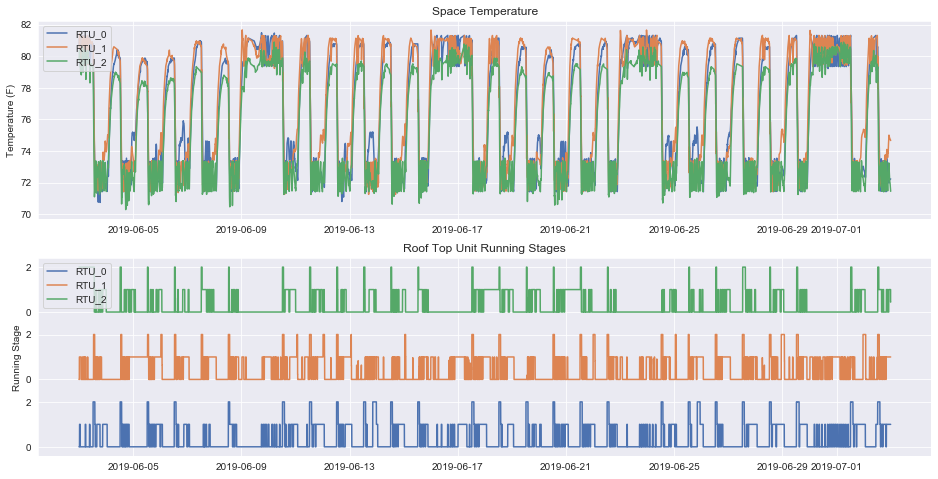

In [6]:
def plot_data(df):
    sptv = df.loc[:, df.columns.str.startswith('sptv')]
    otv = df.loc[:, df.columns == 'otv']
    u = df.loc[:, df.columns.str.startswith('u')]
    
    labels = [f'RTU_{i}' for i in range(3)]
    
    plt.figure(figsize=(16, 8))
    plt.subplot(211)
    plt.title('Space Temperature')
    plt.plot(df.index, sptv)
    plt.ylabel('Temperature (F)')
    plt.legend(labels, loc='upper left')
    plt.subplot(212)
    plt.title('Roof Top Unit Running Stages')
    plt.step(df.index, u.values.reshape(-1, 3, 2).sum(-1) + np.arange(3) * 3.0)
    plt.ylabel('Running Stage')
    plt.yticks([0, 2, 3, 5, 6, 8], [0, 2] * 3)
    plt.legend(labels, loc='upper left')
    plt.show() 

plot_data(raw_data)

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [8]:
from sklearn import preprocessing

def make_dataset(df):
    
    sptv = df.loc[:, df.columns.str.startswith('sptv')].copy()
    u = df.loc[:, df.columns.str.startswith('u')]
    dsptv = ((sptv.shift(-1) - sptv.shift()) / 2)

    sptv.iloc[:] = preprocessing.scale(sptv.values)
    idx = slice(1, -1)
    
    return TensorDataset(*[
        torch.tensor(vals, dtype=torch.float32).to(device=device) for vals in [
            np.hstack([sptv[idx], u[idx]]), dsptv[idx].values
        ]
    ])

In [9]:
class MyModel(nn.Module):
    
    def __init__(self, shape, activation_fn=torch.tanh, before_activation=True):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        for inp, out in zip(shape[:-2], shape[1:-1]):
            self.layers.append(nn.Linear(inp, out, bias=False))
            self.layers.append(nn.BatchNorm1d(out))
            
        self.layers.append(nn.Linear(shape[-2], shape[-1]))
        self.activation_fn = activation_fn
        self.offset = 1 if before_activation else 0
        
    def forward(self, inp):
        x = inp
        
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            
            if (i + self.offset) % 2 == 0:
                x = self.activation_fn(x)
        
        return self.layers[-1](x)

In [10]:
dataset = make_dataset(raw_data)

In [11]:
from sklearn.model_selection import KFold
from IPython.display import clear_output, Markdown


def train_loop(n_epoch, model, optimizer, loss_fn, dataset, batch_size=128):
    loader = DataLoader(dataset, batch_size=batch_size)
    
    with tqdm(range(n_epoch)) as prog:
        for epoch in prog:
            for inp, out in loader:
                loss = loss_fn(model(inp), out)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
    return model.eval()


def run_tests(n_fold=5):
    kf = KFold(n_splits=n_fold)
    
    activate_fns = [
        ('ELU', nn.ELU), ('ReLU', nn.ReLU()), 
        ('LeakyReLU', nn.LeakyReLU()), ('Tanh', nn.Tanh())
    ]
    data = []
    
    for activate_fn_name, activate_fn in activate_fns:
        
        for before_activation in [True, False]:
            for i, (train_index, valid_index) in enumerate(kf.split(dataset)):
                model = MyModel((9, 32, 32, 3), before_activation=before_activation)

                if torch.cuda.is_available():
                    model = model.cuda()

                optimizer = optim.Adam(model.parameters())
                loss_fn = nn.SmoothL1Loss()

                clear_output()
                display(Markdown(
                    f'**ActivationFn**: {activate_fn_name} '
                    f'**Before Activation**: {before_activation} '
                    f'**KF**: {i+1}/{n_fold} '
                ))
                model = train_loop(10, model, optimizer, loss_fn, Subset(dataset, train_index))
                valid_inp, valid_out = dataset[valid_index]
                
                data.append({
                    'activation_fn': activate_fn_name,
                    'batch_norm_before_activation': before_activation,
                    'loss': np.asscalar(loss_fn(model(valid_inp), valid_out).cpu().detach().numpy())
                })
        
    return pd.DataFrame(data)

    
df = run_tests()

**ActivationFn**: Tanh **Before Activation**: False **KF**: 5/5 

100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


In [12]:
df.groupby(['activation_fn', 'batch_norm_before_activation']).agg(np.mean)

loss
activation_fn batch_norm_before_activation          
ELU           False                         0.017621
              True                          0.016005
LeakyReLU     False                         0.017267
              True                          0.016059
ReLU          False                         0.018220
              True                          0.016634
Tanh          False                         0.017579
              True                          0.016057

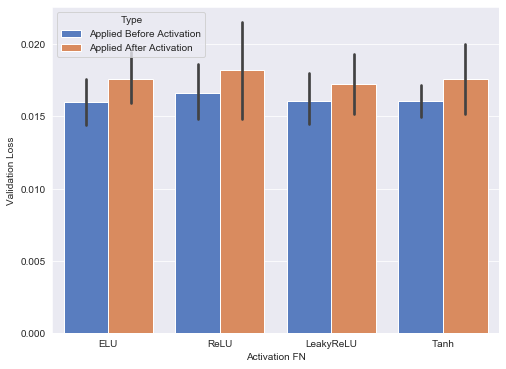

In [16]:
data = df.copy()
data.columns = ['Activation FN', 'Type', 'Validation Loss']
data.Type = data.Type.replace({True: 'Applied Before Activation', False: 'Applied After Activation'})

plt.figure(figsize=(8, 6))
sns.barplot(x='Activation FN', y='Validation Loss', hue='Type', data=data, palette='muted')
plt.savefig('batch_norm_before_or_after.png', bbox_inches='tight')
plt.show()